In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In this notebook, we will look at how stochastic gradient descent (SGD), which is one of the building blocks of neural networks, works for simple quadratic function with some noise. The goal here is to gain fundamental understanding of the SGD process via a simple example. With this understanding, it will be possible to understand how SGD will be applicable to neural networks. To start, the cell above imports a few useful python libraries and also prepares the notebook environment on Kaggle.

Now let us imagine we were measuring the speed of a roller coaster as it went over the top of a hump. Befoe approaching the hump, the speed of the roller coaster will be high but as it goes up the hill it get slower and will be the slowest at the top. It would then speed up again as it starts to go downhill. We would like to build a model of how the speed changes over time. If we were measuring the speed manually every second for 20 seconds, it might look something like this:

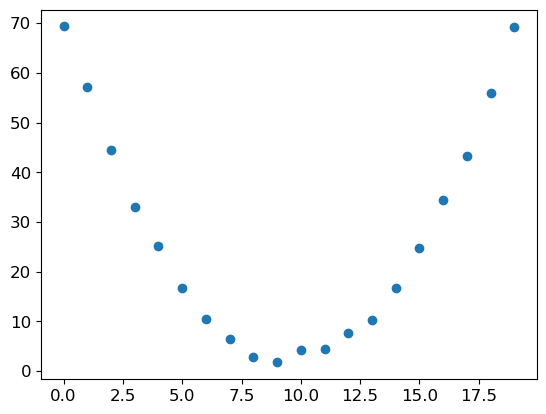

In [59]:
time = torch.arange(0, 20).float(); # we have taken measurements for 20 seconds
speed = torch.rand(20) * 3 + 0.75 * (time - 9.5) ** 2 + 1 # measured speed (hypothetical)
plt.scatter(time, speed); # plot speed vs time to observe the data trend

The distribution looks like a parabola with some noises. The noise is intentionally added to the speed because measuring things manually is never precise. Our goal here is to find a function that matches our imaginary observation dataset shown above. There are infinite number of functions we can try but as we mentioned ealier the distribution looks like a parabola with some noise. So instead of entertaining infinite possible functions we will start with a quadratic function: $at^2 + bt^2 + c$ where a, b and c are the unknown parameters of our assumed function whose independent variable is the time, *t*.

We shall now define our function using Python but before that we want to set the strategy of how this function will accept arguments in terms of the independent variable and the unknown parameters i.e., we want to distinguish clearly between the functions input and its parameters. So let us collect the parameters in one argument and thus separate the input, *t* and the parameters, *params*, in the function's signature:

In [60]:
def f(t, params):
    a, b, c = params
    return a * t ** 2 + b * t + c

We have now restricted the problem of finding the best imaginable function that fits the speed measurement data to finding the best quadratic function which in turn means we need to find the best values for *a, b, c* for fitting to our data. The takeaway here is if we are able to solve this problem of finding best *a, b, c* for this simple example, we will be able to understand how similar approach is taken for more complex functions with more parameters - such as a neural net.

To define what we mean by "best", we will choose a *loss function*, which will return a value based on the a prediction and a target, where lower values of the function correspond to "*better*" predictions. There are several options to choose from and for continuous data, it is fairly common to use *mean squared error (MSE)*:

In [61]:
def mse(preds, targets): return ((preds - targets) ** 2).mean()

Now that we have precisely defined the loss function which enables us to improve our calculation of the parameters, we will walk through a seven step process mapped out by Jeremy Howard and Sylvain Gruger in their awesome book. In fact this notebook is written to practice the concepts introduced in chapter 4 of this greatly useful book.

**Step 1: Initialize the parameters**

First, we initialize the parameters to random values and tell PyToch that we want to track their gradients using requires_grad_():

In [62]:
params = torch.randn(3).requires_grad_()

**Step 2: Calculate the predictions**

Next, we calculate the predictions using the initially random params we have just asked PyToch to give us:

In [63]:
preds = f(time, params)

Let us create a handy little function to see how close our predictions are to our targets, and take a look:

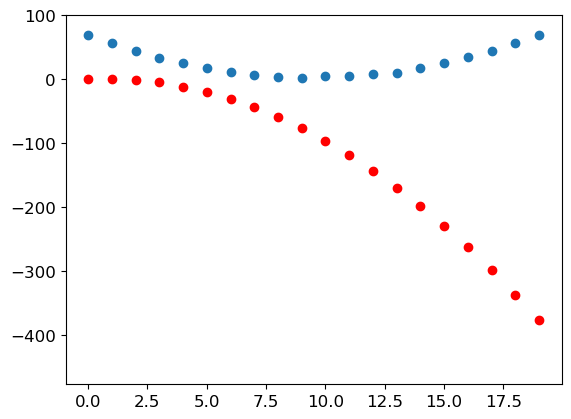

In [64]:
def show_preds(preds, ax=None):
    if ax is None: ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(min(to_np(preds)) - 100, max(to_np(preds)) + 100)
show_preds(preds)

This does not look very close at all. Our random parameters indicate that the speed increases almost monotonically which would violate laws of physics and frictions.

**Step 3: Calculate the loss**

To calculate the loss, we do the following:

In [65]:
loss = mse(preds, speed)
loss

tensor(38854.2500, grad_fn=<MeanBackward0>)

Our goal is now to improve this or make the magnitude of the loss smaller. To do that, we will need to know the gradients.

**Step 4: Calculate the gradients**

The next step is to calculate the gradients, or an approximation of how the parameters need to change in order to improve the loss:

In [66]:
loss.backward()
params.grad, params.grad * 1e-5

(tensor([-65551.0156,  -4181.5347,   -301.5492]),
 tensor([-0.6555, -0.0418, -0.0030]))

We can use these gradients to improve our parameters. We need to pick a learning rate which will determine how rapidly we are changing our parameters based on the gradients. For now we will select it to be 1e-5 and in a later write up I will describe the process of selecting this hyperparameter.

In [67]:
params

tensor([-1.1267,  1.5980,  0.1115], requires_grad=True)

**Step 5: Step the weights**

Now we need to update the parameters based on the gradients we just calculated:

In [68]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

Lets see if the loss has improved:

In [69]:
preds = f(time, params)
mse(preds, speed)

tensor(7897.4829, grad_fn=<MeanBackward0>)

It has! The loss magnitude decreased from 10218.9941 to 2491.4158. Let's see this visually as well:

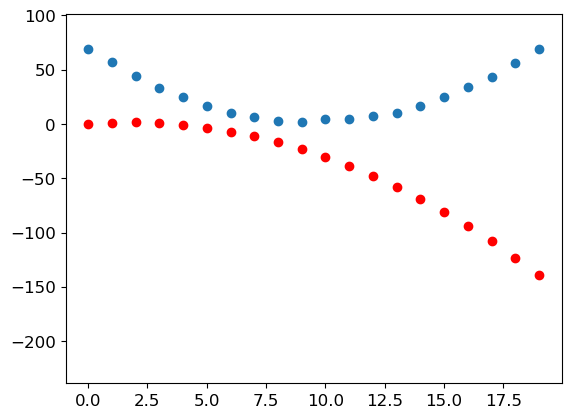

In [70]:
show_preds(preds)

We need to repeat this a few times, so we want to create a function to apply one step:

In [71]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

**Step 6: Repeat the provess**

Now we iterate by looping and performing many improvements which hopefully will take us to a good result:

In [72]:
for i in range(10): apply_step(params)

7897.48291015625
2039.5093994140625
930.9947509765625
721.2233276367188
681.5215454101562
674.0020751953125
672.572509765625
672.2953491210938
672.2362670898438
672.2183837890625


We can see the magnitude of the loss is going down, just as we hoped!. But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function output, we plot the function at every step. This will enable us to see how the shape is approaching the best possible quadratic function for our data:

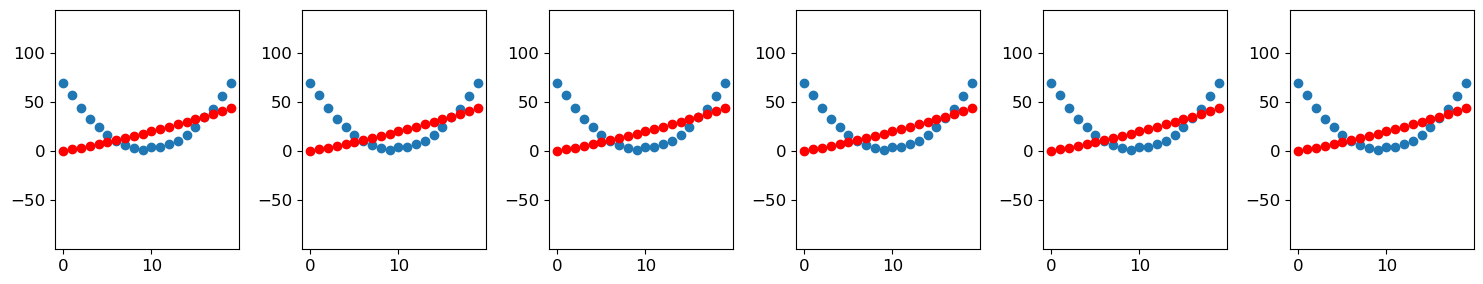

In [73]:
_,axs = plt.subplots(1, 6, figsize=(15, 3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

**Step 7: Stop**

We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop.